# CVE- Common Vulnerabilities and Exposures
cve data extracted into MongoDB using cve-search - https://github.com/cve-search/cve-search

* The extracted data from MongoDB is analyzed in this notebook

## Importing Libraries

In [1]:
#Basic Libararies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import cycle, islice
import string
import re
import pickle

#!pip install unidecode
import unidecode

#nltk
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

#Tensorflow models and layers
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Flatten, Dropout, MaxPool2D, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import GlobalAvgPool1D, GlobalMaxPool1D

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score

#!pip install tensorflow-addons
#import tensorflow_addons as tfa

#WordCloud
#from wordcloud import WordCloud

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#Spacy
import spacy

#Vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# downloading url
import requests 

#warnings
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Connecting to MongoDB

In [3]:
# importing the required libraries
import pymongo
import pprint
import json

# connect to the mongoclient
client = pymongo.MongoClient('mongodb://127.0.0.1:27017')

# get the database
db = client['cvedb']

collection = db.get_collection('cves')

## Loading Data

In [4]:
import pandas as pd

#cursor = collection.find()
#companies = ['intel', 'amd', 'broadcom', 'qualcomm', 'nxp', \
 #            'marvell', 'cisco', 'dell', 'hp', 'supermicro', 'hive', 'gigabyte'] 

#cursor = collection.find( { "vendors" : { "$in": companies} } )

cursor = collection.find()

allitems_df = pd.DataFrame(list(cursor))

#allitems_df.to_csv("selected-vendors_cves.csv")
#allitems_df.to_csv("allitems_df.csv")

allitems_df.head(5)

,_id,id,assigner,Published,Modified,last-modified,summary,access,impact,impact3,...,cvss-vector,references,vulnerable_configuration,vulnerable_product,vendors,products,vulnerable_product_stems,vulnerable_configuration_stems,cwe,vulnerable_configuration_cpe_2_2
0,623bf1aeca8a30683f12653a,CVE-2018-0004,sirt@juniper.net,2018-01-10 22:29:00,2019-10-09 23:30:00,2019-10-09 23:30:00,A sustained sequence of different types of nor...,"{'authentication': 'NONE', 'complexity': 'MEDI...","{'availability': 'COMPLETE', 'confidentiality'...","{'availability': 'HIGH', 'confidentiality': 'N...",...,AV:N/AC:M/Au:N/C:N/I:N/A:C,"[https://kb.juniper.net/JSA10832, http://www.s...",[cpe:2.3:o:juniper:junos:12.1x46:d20:*:*:*:*:*...,[cpe:2.3:o:juniper:junos:12.1x46:d20:*:*:*:*:*...,[juniper],[junos],[cpe:2.3:o:juniper:junos],[cpe:2.3:o:juniper:junos],CWE-400,[]
1,623bf1aeca8a30683f12653b,CVE-2016-0013,cve@mitre.org,2017-05-11 14:29:00,2017-05-11 14:29:00,2017-05-11 14:29:00,** REJECT ** DO NOT USE THIS CANDIDATE NUMBER...,{},{},NaN,...,NaN,[],[],[],[],[],[],[],Unknown,[]
2,623bf1aeca8a30683f12653c,CVE-2005-0002,cve@mitre.org,2005-05-02 04:00:00,2008-09-10 19:34:00,2008-09-10 19:34:00,"poppassd_pam 1.0 and earlier, when changing a ...","{'authentication': 'NONE', 'complexity': 'LOW'...","{'availability': 'COMPLETE', 'confidentiality'...",NaN,...,AV:N/AC:L/Au:N/C:C/I:C/A:C,[http://security.gentoo.org/glsa/glsa-200501-2...,[cpe:2.3:a:gentoo:poppassd_pam:-:*:*:*:*:*:*:*...,[cpe:2.3:a:gentoo:poppassd_pam:-:*:*:*:*:*:*:*...,[gentoo],[poppassd_pam],[cpe:2.3:a:gentoo:poppassd_pam],[cpe:2.3:a:gentoo:poppassd_pam],NVD-CWE-Other,[]
3,623bf1aeca8a30683f12653d,CVE-2003-0012,cve@mitre.org,2003-01-17 05:00:00,2016-10-18 02:28:00,2016-10-18 02:28:00,The data collection script for Bugzilla 2.14.x...,"{'authentication': 'NONE', 'complexity': 'LOW'...","{'availability': 'NONE', 'confidentiality': 'N...",NaN,...,AV:L/AC:L/Au:N/C:N/I:P/A:N,[http://www.iss.net/security_center/static/109...,[cpe:2.3:a:mozilla:bugzilla:2.14.4:*:*:*:*:*:*...,[cpe:2.3:a:mozilla:bugzilla:2.14.4:*:*:*:*:*:*...,[mozilla],[bugzilla],[cpe:2.3:a:mozilla:bugzilla],[cpe:2.3:a:mozilla:bugzilla],NVD-CWE-Other,[]
4,623bf1aeca8a30683f12653e,CVE-2011-0003,secalert@redhat.com,2011-01-11 03:00:00,2017-08-17 01:33:00,2017-08-17 01:33:00,"MediaWiki before 1.16.1, when user or site Jav...","{'authentication': 'NONE', 'complexity': 'MEDI...","{'availability': 'NONE', 'confidentiality': 'P...",NaN,...,AV:N/AC:M/Au:N/C:P/I:P/A:N,[http://www.openwall.com/lists/oss-security/20...,[cpe:2.3:a:mediawiki:mediawiki:1.10.3:*:*:*:*:...,[cpe:2.3:a:mediawiki:mediawiki:1.10.3:*:*:*:*:...,[mediawiki],[mediawiki],[cpe:2.3:a:mediawiki:mediawiki],[cpe:2.3:a:mediawiki:mediawiki],CWE-20,[]


In [5]:
allitems_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183006 entries, 0 to 183005
Data columns (total 29 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   _id                               183006 non-null  object        
 1   id                                183006 non-null  object        
 2   assigner                          183006 non-null  object        
 3   Published                         183006 non-null  datetime64[ns]
 4   Modified                          183006 non-null  datetime64[ns]
 5   last-modified                     183006 non-null  datetime64[ns]
 6   summary                           183006 non-null  object        
 7   access                            183006 non-null  object        
 8   impact                            183006 non-null  object        
 9   impact3                           98594 non-null   object        
 10  exploitability3                 

## Cleaning and Labeling Data

In [6]:
def get_value(x):
    if len(x)==0:
        return np.nan
    else:
        return x[0].split(':')[2]

z = allitems_df.vulnerable_configuration.map(lambda x: get_value(x))
z.value_counts()

a    133737
o     35926
h      2166
Name: vulnerable_configuration, dtype: int64

In [7]:
def get_label(x):
    if len(x)==0:
        return np.nan
    elif x[0].split(':')[2]=='h':
        return 1
    else:
        return 0
    
final_df = allitems_df[['id','summary','vulnerable_configuration']].copy().rename(columns={'id': 'cve_id'})
final_df['label'] = allitems_df.vulnerable_configuration.map(lambda x: get_label(x))
final_df = final_df.dropna().reset_index(drop=True).drop(columns=['vulnerable_configuration'])
final_df['label']=final_df.label.astype(np.int32)
final_df

,cve_id,summary,label
0,CVE-2018-0004,A sustained sequence of different types of nor...,0
1,CVE-2005-0002,"poppassd_pam 1.0 and earlier, when changing a ...",0
2,CVE-2003-0012,The data collection script for Bugzilla 2.14.x...,0
3,CVE-2011-0003,"MediaWiki before 1.16.1, when user or site Jav...",0
4,CVE-2019-0005,"On EX2300, EX3400, EX4600, QFX3K and QFX5K ser...",0
...,...,...,...
171824,CVE-2020-6619,stb stb_truetype.h through 1.22 has an asserti...,0
171825,CVE-2019-9735,An issue was discovered in the iptables firewa...,0
171826,CVE-2019-9736,DOM-based XSS exists in 1024Tools Markdown 1.0...,0
171827,CVE-2019-9737,Editor.md 1.5.0 has DOM-based XSS via vectors ...,0


In [8]:
#final_df[final_df['label']==1][['cve_id', 'summary']].reset_index(drop=True).to_csv('hardware_cves.csv')

In [9]:
final_df[final_df.cve_id=='CVE-2003-0125'].summary.values

array(['Buffer overflow in the web interface for SOHO Routefinder 550 before firmware 4.63 allows remote attackers to cause a denial of service (reboot) and execute arbitrary code via a long GET /OPTIONS value.'],
      dtype=object)

In [10]:
final_df[final_df.cve_id=='CVE-2019-9536'].summary.values

array(["Apple iPhone 3GS bootrom malloc implementation returns a non-NULL pointer when unable to allocate memory, aka 'alloc8'. An attacker with physical access to the device can install arbitrary firmware."],
      dtype=object)

In [11]:
final_df[final_df.cve_id=='CVE-2021-38154'].summary.values

array(['Certain Canon devices manufactured in 2012 through 2020 (such as imageRUNNER ADVANCE iR-ADV C5250), when Catwalk Server is enabled for HTTP access, allow remote attackers to modify an e-mail address setting, and thus cause the device to send sensitive information through e-mail to the attacker. For example, an incoming FAX may be sent through e-mail to the attacker. This occurs when a PIN is not required for General User Mode, as exploited in the wild in August 2021.'],
      dtype=object)

In [12]:
final_df[final_df.cve_id=='CVE-2022-0002'].summary.values

array(['Non-transparent sharing of branch predictor within a context in some Intel(R) Processors may allow an authorized user to potentially enable information disclosure via local access.'],
      dtype=object)

In [13]:
final_df.label.value_counts()

0    169663
1      2166
Name: label, dtype: int64

## Text pre-processing

In [14]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(final_df.summary)

print (data_words[0][0:20])

['sustained', 'sequence', 'of', 'different', 'types', 'of', 'normal', 'transit', 'traffic', 'can', 'trigger', 'high', 'cpu', 'consumption', 'denial', 'of', 'service', 'condition', 'in', 'the']


In [39]:
def spacy_lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(" ".join(text))
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


def nltk_lemmatization(texts):
    stem = WordNetLemmatizer()
    texts_out=[]
    for text in texts:
        text = " ".join((stem.lemmatize(word) for word in text))
        texts_out.append(text)
    return texts_out

def nltk_stemming(texts):
    stem = PorterStemmer()
    texts_out=[]
    for text in texts:
        text = " ".join((stem.stem(word) for word in text))
        texts_out.append(text)
    return texts_out


lemmatized_texts = spacy_lemmatization(data_words)
print (lemmatized_texts[0][0:90])

sustained sequence different type normal transit traffic trigger high cpu consumption deni


In [40]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'vulnerability','allow','attackers','attacker','user', 'arbitrary','remote','include','privilege'])

# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(lemmatized_texts)

In [41]:
data=[]
for list in data_words_nostops:
    text = " ".join(list)
    data.append([text])

In [42]:
"""Text vectorization using keras"""
max_tokens=20000
output_sequence_length=500
ngrams = 1
output_mode = 'int'
text_vectorization = TextVectorization(max_tokens = max_tokens, 
                                               ngrams=ngrams, 
                                               output_sequence_length=output_sequence_length, 
                                               output_mode=output_mode)
text_vectorization.adapt(data)

In [43]:
# X and y allocation
X = text_vectorization(data).numpy()
#y = tf.keras.utils.to_categorical(final_df[['label']], num_classes=2)
y = final_df[['label']]

#display vocabulary
vocabulary = text_vectorization.get_vocabulary()
vocabulary

['',
 '[UNK]',
 'allow',
 'attacker',
 'vulnerability',
 'remote',
 'arbitrary',
 'user',
 'file',
 'version',
 'code',
 'execute',
 'service',
 'php',
 'cause',
 'server',
 'access',
 'denial',
 'craft',
 'parameter',
 'use',
 'web',
 'early',
 'information',
 'site',
 'issue',
 'vector',
 'unspecified',
 'affect',
 'attack',
 'privilege',
 'cross',
 'local',
 'application',
 'command',
 'memory',
 'oracle',
 'request',
 'xss',
 'function',
 'datum',
 'system',
 'overflow',
 'script',
 'prior',
 'scripting',
 'buffer',
 'window',
 'device',
 'read',
 'base',
 'aka',
 'obtain',
 'inject',
 'injection',
 'exploit',
 'component',
 'crash',
 'execution',
 'multiple',
 'android',
 'lead',
 'result',
 'product',
 'sql',
 'sensitive',
 'cvss',
 'impact',
 'authenticate',
 'exist',
 'network',
 'sp',
 'successful',
 'discover',
 'directory',
 'malicious',
 'relate',
 'bypass',
 'possibly',
 'properly',
 'note',
 'page',
 'management',
 'security',
 'password',
 'corruption',
 'sd',
 'process'

In [44]:
X.shape

(171829, 500)

In [45]:
y.shape

(171829, 1)

**Data reload**

In [3]:
#np.save('X.npy', X)    # .npy extension is added if not given
d = np.load('X.npy')
#(X == d).all()

In [4]:
#np.save('y.npy', y)    # .npy extension is added if not given
e = np.load('y.npy')
#(y == e).all()

In [5]:
X = d.copy()
y = e.copy()

## Splitting the data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,
                                                    stratify = y,
                                                    shuffle=True,
                                                    random_state=42
                                                   )

In [7]:
pd.Series(y_test.flatten()).value_counts()

0    33933
1      433
dtype: int64

<AxesSubplot:>

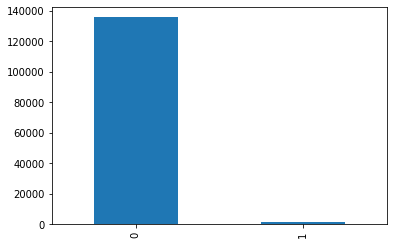

In [8]:
#y_label = pd.Series(np.argmax(y_train, axis=1))
pd.Series(y_train.flatten()).value_counts().plot(kind='bar')

## Method 1: Down Sampling

In [ ]:
from imblearn.datasets import make_imbalance

X_train, y_train = make_imbalance(X_train, y_train, sampling_strategy={0: 1733, 1: 1733}, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

In [ ]:
pd.Series(np.argmax(y_train, axis=1)).value_counts().plot(kind='bar')
#y_train.value_counts().plot(kind='bar')
plt.title('label balance')
plt.xlabel('label values')
plt.ylabel('amount per label')
plt.show()

## Method 2: Up Sampling (Smote)

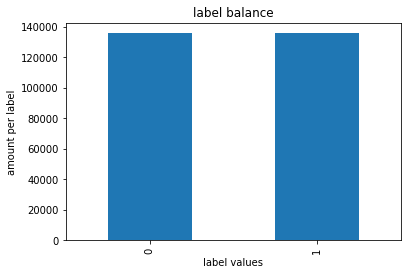

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

pd.Series(np.argmax(y_train, axis=1)).value_counts().plot(kind='bar')
#pd.Series(y_train.flatten()).value_counts().plot(kind='bar')
plt.title('label balance')
plt.xlabel('label values')
plt.ylabel('amount per label')
plt.show()

## Model

### LSTM

In [10]:
# Hyper-Parameters
output_nodes = 2

out_activation = 'softmax' #sigmoid

loss_func =  tf.keras.metrics.categorical_crossentropy, #tf.keras.metrics.binary_crossentropy,

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)

num_lstm_layers = 1

pooling = False

num_hidden_layers = 1

input_dim = 20000 #len(vocabulary) #Size of the vocabulary i.e. maximum integer index + 1

output_dim = 10 #Dimention of the dense embedding layer

input_length = X_train.shape[-1] #number of columns after vectorization should be provided here

tf.keras.backend.clear_session()


def lstm_model(output_nodes,
          input_dim,
          output_dim,
          input_length,
          num_units = 256,
          num_lstm_layers = 1,
          dropout_rate = 0.4,
          recurrent_dropout = 0,
          pooling = False,
          pooling_type = 'global_avg',
          num_hidden_layers = 0,
          num_dense_units = 64,
          dense_dropout = 0.2,
          dense_activation = 'relu',
          out_activation = 'softmax',
          loss_func = tf.keras.metrics.categorical_crossentropy,
          optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
         ):
    
    model = Sequential()
    
    #Embedding layer to embed the text vectors as an encoded data so, it can be input for the model
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)) 
    
    #LSTM block
    for i in range(num_lstm_layers):
            model.add(LSTM(num_units, 
                           dropout=dropout_rate, 
                         #activation='tanh', 
                     #recurrent_activation='sigmoid',
                     recurrent_dropout=recurrent_dropout, 
                     #use_bias=True, unroll=False,
                     return_sequences=True))
    
    #Pooling layers to reduce dimentions and so, to reduce parameters
    if pooling:
        if pooling_type=='global_avg':
            model.add(GlobalAvgPool1D())
        if pooling_type=='global_max':
            model.add(GlobalMaxPool1D())
    else:
    #Flattening the 2D array to 1D before passing to Fully-Connected network or to the output layer
      model.add(Flatten())
    
    #Fully-Connected layers
    for i in range(num_hidden_layers):
        model.add(Dense(num_dense_units, activation=dense_activation))
        model.add(Dropout(dense_dropout))
    model.add(Dense(output_nodes, activation=out_activation)) #Using two nodes as ouput #softmax

    #Compiling the model (for backpropogation)
    model.compile(
        loss = loss_func, 
        optimizer = optimizer,
        metrics = ["accuracy"] #, tfa.metrics.F1Score(2)
    )
    
    return model


model = lstm_model(output_nodes=output_nodes,
              input_dim=input_dim, 
              output_dim=output_dim, 
              num_lstm_layers=num_lstm_layers,
              input_length=input_length, 
              pooling=pooling,
              num_hidden_layers=num_hidden_layers,
              out_activation = out_activation,
              loss_func = loss_func,
              optimizer = optimizer, 
                  )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 10)           200000    
_________________________________________________________________
lstm (LSTM)                  (None, 500, 256)          273408    
_________________________________________________________________
flatten (Flatten)            (None, 128000)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                8192064   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 8,665,602
Trainable params: 8,665,602
Non-trainable params: 0
______________________________________________

In [12]:
EPOCHS = 10
BATCH_SIZE = 512

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="lstm.h5",
                                            save_best_only=True,
                                            monitor='val_loss')
#tf.keras.backend.clear_session()

history = model.fit(X_train, #X_train, 
                    y_train, #y_train, 
                    validation_split=0.2,
                    shuffle=True, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    callbacks=[checkpoint]
                   )

Epoch 1/10
425/425 [==============================] - 152s 348ms/step - loss: 0.3477 - accuracy: 0.8479 - val_loss: 0.3460 - val_accuracy: 0.8540
Epoch 2/10
425/425 [==============================] - 149s 350ms/step - loss: 0.2327 - accuracy: 0.9200 - val_loss: 0.2886 - val_accuracy: 0.8683
Epoch 3/10
425/425 [==============================] - 150s 352ms/step - loss: 0.1584 - accuracy: 0.9425 - val_loss: 0.1636 - val_accuracy: 0.9321
Epoch 4/10
425/425 [==============================] - 150s 354ms/step - loss: 0.1335 - accuracy: 0.9516 - val_loss: 0.1321 - val_accuracy: 0.9461
Epoch 5/10
425/425 [==============================] - 150s 354ms/step - loss: 0.1204 - accuracy: 0.9561 - val_loss: 0.0821 - val_accuracy: 0.9675
Epoch 6/10
425/425 [==============================] - 151s 354ms/step - loss: 0.1068 - accuracy: 0.9617 - val_loss: 0.1040 - val_accuracy: 0.9572
Epoch 7/10
425/425 [==============================] - 151s 356ms/step - loss: 0.1000 - accuracy: 0.9645 - val_loss: 0.1279 -

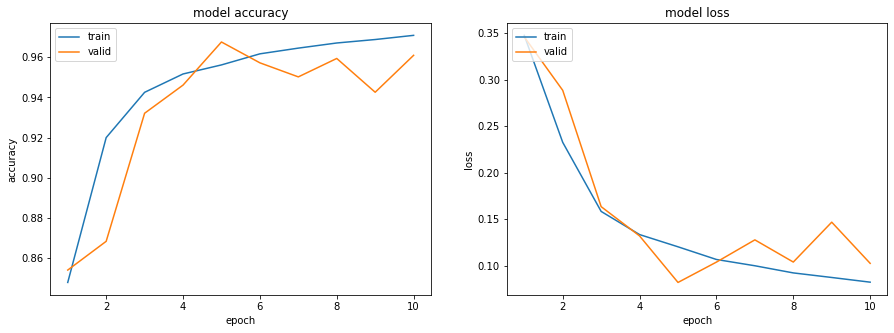

In [13]:
def plot_train_val_accuracy_n_loss(history, Range=2.0):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for ax, j in zip(axes, ['accuracy', 'loss']):
        # summarize history for accuracy and loss
        ax.plot(range(1, len(history.history[j]) + 1), history.history[j])
        ax.plot(range(1, len(history.history['val_'+j]) + 1), history.history['val_'+j])
        ax.set_title("model "+j)
        ax.set_ylabel(j)
        ax.set_xlabel('epoch')
        ax.set_xticks(np.arange(2,EPOCHS+1, Range))
        ax.legend(['train', 'valid'], loc='upper left')
    plt.show()
        
plot_train_val_accuracy_n_loss(history)

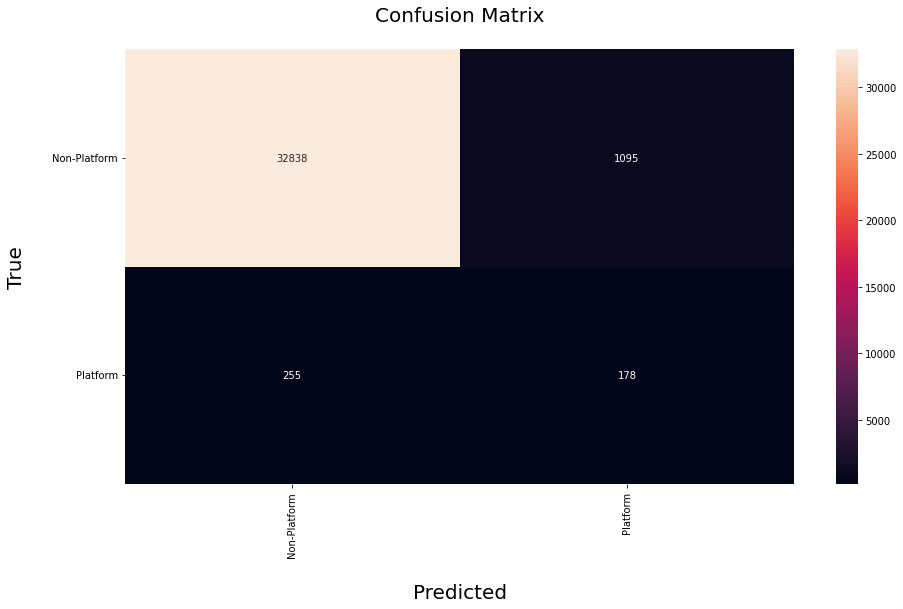

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     33933
           1       0.14      0.41      0.21       433

    accuracy                           0.96     34366
   macro avg       0.57      0.69      0.59     34366
weighted avg       0.98      0.96      0.97     34366



In [38]:
model = tf.keras.models.load_model("lstm.h5")

# Changinge one hot encoded data back to labels
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test.flatten()

# Class Labels
class_names = ['Non-Platform', 'Platform']

# Plotting Confusion matrix
cm = confusion_matrix(y_true, y_pred)
#cm = confusion_matrix(y_test, y_pred)


def plot_confusion_matrix(cm, class_names=class_names):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(15, 8))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('\nPredicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True\n', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix\n', fontsize=20)
    plt.show()

plot_confusion_matrix(cm)

print(classification_report(y_true, y_pred, labels=[0, 1]))

### Bidirectional LSTM

In [11]:
# Hyper-Parameters
output_nodes = 2

out_activation = 'softmax'

loss_func =  tf.keras.metrics.categorical_crossentropy, #tf.keras.metrics.binary_crossentropy, 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)

bidirectional = True

num_units = 64

num_lstm_layers = 2

pooling = False

num_hidden_layers = 1

input_dim = 20000 #len(vocabulary) #Size of the vocabulary i.e. maximum integer index + 1

output_dim = 10 #Dimention of the dense embedding layer

input_length = X_train.shape[-1] #number of columns after vectorization should be provided here

tf.keras.backend.clear_session()


def lstm_model(output_nodes,
          input_dim,
          output_dim,
          input_length,
          bidirectional=False,
          num_units = 256,
          num_lstm_layers = 1,
          dropout_rate = 0.4,
          recurrent_dropout = 0,
          pooling = False,
          pooling_type = 'global_avg',
          num_hidden_layers = 0,
          num_dense_units = 64,
          dense_dropout = 0.2,
          dense_activation = 'relu',
          out_activation = 'softmax',
          loss_func = tf.keras.metrics.categorical_crossentropy,
          optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
         ):
    
    model = Sequential()
    
    #Embedding layer to embed the text vectors as an encoded data so, it can be input for the model
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)) 
    
    #LSTM block
    for i in range(num_lstm_layers):
        if i==num_lstm_layers-1 and bidirectional == False:
            model.add(LSTM(num_units, 
                           dropout=dropout_rate, 
                         #activation='tanh', 
                     #recurrent_activation='sigmoid',
                     recurrent_dropout=recurrent_dropout, 
                     #use_bias=True, unroll=False,
                     #return_sequences=True
                          ))
        elif i==num_lstm_layers-1 and bidirectional == True:
            model.add(Bidirectional(LSTM(num_units, 
                           dropout=dropout_rate, 
                         #activation='tanh', 
                     #recurrent_activation='sigmoid',
                     recurrent_dropout=recurrent_dropout, 
                     #use_bias=True, unroll=False,
                     #return_sequences=True
                                        )))
        elif i!=num_lstm_layers-1 and bidirectional == True:
            model.add(Bidirectional(LSTM(num_units, 
                           dropout=dropout_rate, 
                         #activation='tanh', 
                     #recurrent_activation='sigmoid',
                     recurrent_dropout=recurrent_dropout, 
                     #use_bias=True, unroll=False,
                     return_sequences=True)))
        else:
            model.add(LSTM(num_units, 
                           dropout=dropout_rate, 
                         #activation='tanh', 
                     #recurrent_activation='sigmoid',
                     recurrent_dropout=recurrent_dropout, 
                     #use_bias=True, unroll=False,
                     return_sequences=True))
    
    #Pooling layers to reduce dimentions and so, to reduce parameters
    if pooling:
        if pooling_type=='global_avg':
            model.add(GlobalAvgPool1D())
        if pooling_type=='global_max':
            model.add(GlobalMaxPool1D())
    #else:
    #Flattening the 2D array to 1D before passing to Fully-Connected network or to the output layer
     # model.add(Flatten())
    
    #Fully-Connected layers
    for i in range(num_hidden_layers):
        model.add(Dense(num_dense_units, activation=dense_activation))
        model.add(Dropout(dense_dropout))
    model.add(Dense(output_nodes, activation=out_activation)) #Using two nodes as ouput #softmax

    #Compiling the model (for backpropogation)
    model.compile(
        loss = loss_func, 
        optimizer = optimizer,
        metrics = ["accuracy"] #, tfa.metrics.F1Score(2)
    )
    
    return model


model = lstm_model(output_nodes=output_nodes,
              input_dim=input_dim, 
              output_dim=output_dim, 
              bidirectional=bidirectional,
              num_units = num_units,
              num_lstm_layers=num_lstm_layers,
              input_length=input_length, 
              pooling=pooling,
              num_hidden_layers=num_hidden_layers,
              out_activation = out_activation,
              loss_func = loss_func,
              optimizer = optimizer, 
                  )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 10)           200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 128)          38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 345,602
Trainable params: 345,602
Non-trainable params: 0
__________________________________________________

In [12]:
EPOCHS = 10
BATCH_SIZE = 512

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="bi_lstm.h5",
                                            save_best_only=True,
                                            monitor='val_loss')
#tf.keras.backend.clear_session()

history = model.fit(X_train, #X_train, 
                    y_train, #y_train, 
                    validation_split=0.2,
                    shuffle=True,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    callbacks=[checkpoint]
                   )

Epoch 1/10
425/425 [==============================] - 432s 999ms/step - loss: 0.3251 - accuracy: 0.8577 - val_loss: 0.2276 - val_accuracy: 0.9024
Epoch 2/10
425/425 [==============================] - 169s 397ms/step - loss: 0.1783 - accuracy: 0.9327 - val_loss: 0.0996 - val_accuracy: 0.9596
Epoch 3/10
425/425 [==============================] - 182s 428ms/step - loss: 0.1218 - accuracy: 0.9561 - val_loss: 0.1452 - val_accuracy: 0.9407
Epoch 4/10
425/425 [==============================] - 163s 384ms/step - loss: 0.1001 - accuracy: 0.9645 - val_loss: 0.0795 - val_accuracy: 0.9685
Epoch 5/10
425/425 [==============================] - 211s 497ms/step - loss: 0.0880 - accuracy: 0.9689 - val_loss: 0.1466 - val_accuracy: 0.9428
Epoch 6/10
425/425 [==============================] - 166s 391ms/step - loss: 0.0810 - accuracy: 0.9714 - val_loss: 0.0972 - val_accuracy: 0.9623
Epoch 7/10
425/425 [==============================] - 164s 386ms/step - loss: 0.0727 - accuracy: 0.9746 - val_loss: 0.1479 -

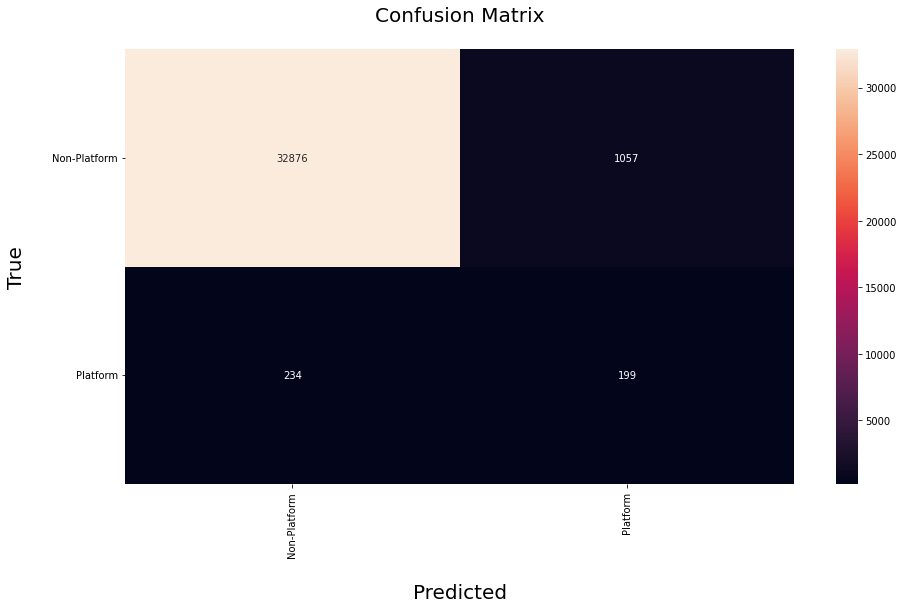

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     33933
           1       0.16      0.46      0.24       433

    accuracy                           0.96     34366
   macro avg       0.58      0.71      0.61     34366
weighted avg       0.98      0.96      0.97     34366



In [13]:
model = tf.keras.models.load_model("bi_lstm.h5")

# Changinge one hot encoded data back to labels
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test.flatten()

# Class Labels
class_names = ['Non-Platform', 'Platform']

# Plotting Confusion matrix
cm = confusion_matrix(y_true, y_pred)
#cm = confusion_matrix(y_test, y_pred)


def plot_confusion_matrix(cm, class_names=class_names):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(15, 8))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('\nPredicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True\n', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix\n', fontsize=20)
    plt.show()

plot_confusion_matrix(cm)

print(classification_report(y_true, y_pred, labels=[0, 1]))